# Analysis of Net Worth, Average Living Area and Rent Prices in Zürich

In the following sections we will analyse the following things:
1. Time Evolution of Net Worth in Zürich
2. Connection between Median Net Worth, Average Living Area and Rent Prices
  
The analysis is carried out districtwise in the city of Zürich.

Sources can be found at the [end of the script](#sources).

## 0. Preparation

In [2]:
# import libraries
import numpy as np
import scipy.stats as stats
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import TwoSlopeNorm, LogNorm
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Custom normalization function to ensure 100 is yellow/white
class CustomLogNorm(LogNorm):
    def __call__(self, value, clip=None):
        normalized_value = super().__call__(value, clip)
        return normalized_value - super().__call__(100, clip) + 0.5

## 1. Time Evolution of Net Worth in Zürich

### 1.1 Absolut change of Median Net Worth in Zürich (Tax-Bracket wise)

/Users/balu/anaconda3/envs/AML/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'data.gpkg': 'stzh.adm_statistische_quartiere_v' (default), 'stzh.adm_statistische_quartiere_b_p', 'stzh.adm_statistische_quartiere_map'. Specify layer parameter to avoid this warning.
  result = read_func(


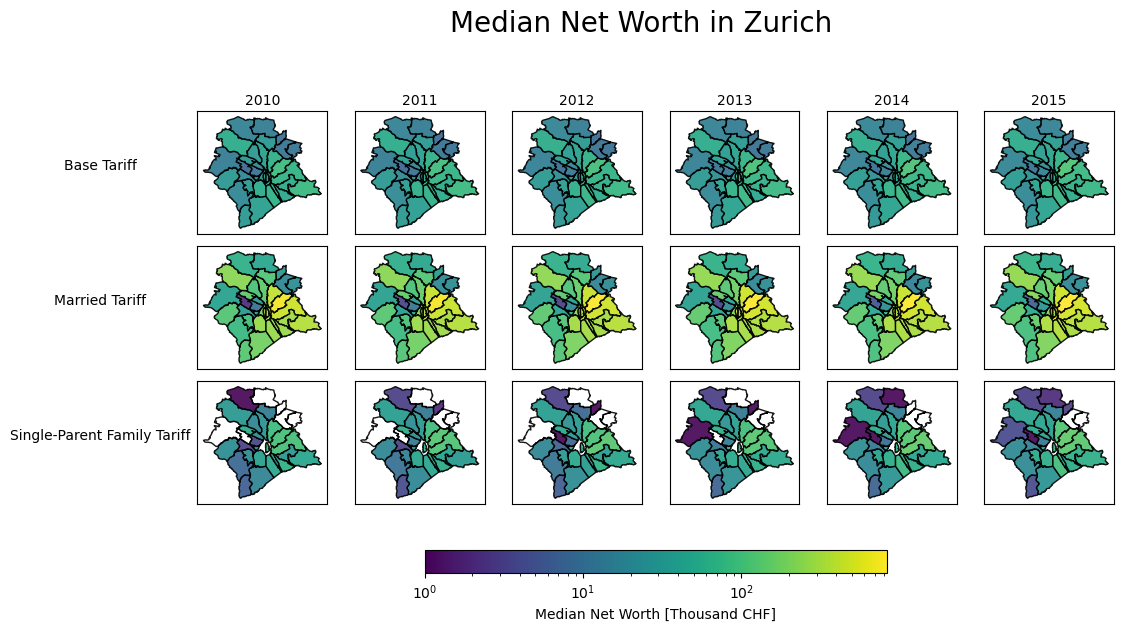

In [ ]:
Bezirke = gpd.read_file('data.gpkg')
Vermoegen = pd.read_csv('MedianVermögen.csv')

data_merged = pd.merge(Vermoegen, Bezirke, left_on='QuarLang', right_on='qname')
data_merged = gpd.GeoDataFrame(data_merged, geometry='geometry')
data_merged = data_merged[['StichtagDatJahr','QuarLang','SteuerTarifLang','SteuerVermoegen_p50','geometry']]
data_merged.SteuerTarifLang = data_merged.SteuerTarifLang.map({'Grundtarif' : 'Base Tariff' , 'Verheiratetentarif' : 'Married Tariff' , 'Einelternfamilientarif' : 'Single-Parent Family Tariff'})
data_merged.columns = ['Year','District','TaxClass','MedianNetWorth','geometry']
data_merged = data_merged[(data_merged.Year >= 2010) & (data_merged.Year <= 2015)]

# Define the shared color scale using logarithmic normalization
vmin = data_merged['MedianNetWorth'].min() + 1  # Minimum value across all data
vmax = data_merged['MedianNetWorth'].max()  # Maximum value across all data

# Use LogNorm for a logarithmic scale
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

years = data_merged.Year.unique()
Klasse = data_merged.TaxClass.unique()

# Create the subplots grid with additional space for titles
fig, axes = plt.subplots(nrows=len(Klasse), ncols=len(years), figsize=(12, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Median Net Worth in Zurich', fontsize=20, y=1.05)

for row_idx in range(len(Klasse)):  # Iterate over rows
    axes[row_idx, 0].set_ylabel(Klasse[row_idx], fontsize=10, rotation=0, labelpad=70)  # Row labels
    for col_idx in range(len(years)):  # Iterate over columns
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(str(years[col_idx]), fontsize=10, pad=5)  # Column labels

        ax = axes[row_idx, col_idx]  # Access the subplot at (row_idx, col_idx)

        # Select data for the current subplot based on row and column features
        if row_idx < len(Klasse) and col_idx < len(years):
            selected_data = data_merged[
                (data_merged['TaxClass'] == Klasse[row_idx]) &
                (data_merged['Year'] == years[col_idx])
            ]

            # Plot the selected data
            if not selected_data.empty:
                selected_data.plot(
                    ax=ax,
                    column='MedianNetWorth',
                    cmap='viridis',
                    norm=norm,  # Use logarithmic normalization
                    legend=False,  # Suppress individual colorbars
                    edgecolor='black',
                    alpha=0.9,
                    aspect='equal'  # Ensure all boxes are of the same size

                )

        # Clean up the subplot for better readability
        ax.set_xticks([])
        ax.set_yticks([])

# Add a single global colorbar with a logarithmic scale
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Needed for ScalarMappable
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Median Net Worth [Thousand CHF]')

plt.savefig('Plots/MedianNetWorthZurich.pdf', bbox_inches='tight')
plt.show()


As can be seen in the above plot, married households generally have a larger net worth in Zürich. In the following we want to analyse the evolution of the median net worth.

### 1.2 Relative change of Median Net Worth in Zürich (Tax-Bracket wise)

In a first step, we need to preprocess the data.

In [5]:
# extract the data points having no data about the median net worth
problem_data = data_merged[(data_merged['MedianNetWorth'] == 0)]
problem_districts_2010 = problem_data.District[problem_data['Year'] == 2010]

# create a new dataframe without the datapoints having district name in problem_districts_2010 and being of TaxClass 'Single-Parent Family Tariff'
new_data = data_merged[~(data_merged['District'].isin(problem_districts_2010) & (data_merged['TaxClass'] == 'Single-Parent Family Tariff'))]

use_data = new_data
# calculate the percentage change in median net worth for each district and tax class
change = use_data.pivot_table(index=['District', 'TaxClass'], columns='Year', values='MedianNetWorth')
change = change.div(change[2010], axis=0) * 100
change = change.reset_index().melt(id_vars=['District', 'TaxClass'], value_vars=years, var_name='Year', value_name='Change')

# Merge with new_data to include geometry
change = pd.merge(change, new_data[['District', 'TaxClass', 'geometry']].drop_duplicates(), on=['District', 'TaxClass'])
change = gpd.GeoDataFrame(change, geometry='geometry')

Next, we plot the change in median net worth to get a rough idea of the evolution.

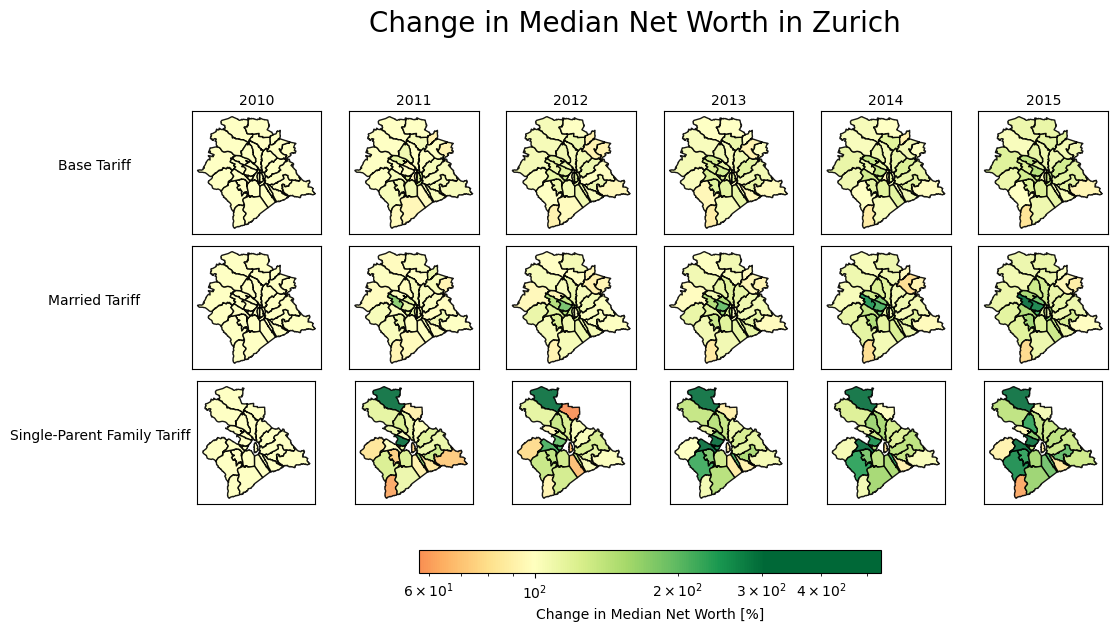

In [6]:
# Define the shared color scale using LogNorm
vmin = change['Change'].min()  # Minimum value across all data
vmax = change['Change'].max()  # Maximum value across all data

norm = CustomLogNorm(vmin=vmin, vmax=vmax)

years = change.Year.unique()
Klasse = change.TaxClass.unique()

# Create the subplots grid with additional space for titles
fig, axes = plt.subplots(nrows=len(Klasse), ncols=len(years), figsize=(12, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Change in Median Net Worth in Zurich', fontsize=20, y=1.05)

for row_idx in range(len(Klasse)):  # Iterate over rows
    axes[row_idx, 0].set_ylabel(Klasse[row_idx], fontsize=10, rotation=0, labelpad=70)  # Row labels
    for col_idx in range(len(years)):  # Iterate over columns
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(str(years[col_idx]), fontsize=10, pad=5)  # Column labels

        ax = axes[row_idx, col_idx]  # Access the subplot at (row_idx, col_idx)

        # Select data for the current subplot based on row and column features
        if row_idx < len(Klasse) and col_idx < len(years):
            selected_data = change[
                (change['TaxClass'] == Klasse[row_idx]) &
                (change['Year'] == years[col_idx])
            ]

            # Plot the selected data
            if not selected_data.empty:
                selected_data.plot(
                    ax=ax,
                    column='Change',
                    cmap='RdYlGn',
                    norm=norm,  # Use custom logarithmic normalization
                    legend=False,  # Suppress individual colorbars
                    edgecolor='black',
                    alpha=0.9,
                    aspect='equal'  # Ensure all boxes are of the same size
                )

        # Clean up the subplot for better readability
        ax.set_xticks([])
        ax.set_yticks([])

# Add a single global colorbar with a logarithmic scale
sm = mpl.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array([])  # Needed for ScalarMappable
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)

cbar.set_label('Change in Median Net Worth [%]')

plt.savefig('Plots/ChangeMedianNetWorthZurich.pdf', bbox_inches='tight')
plt.show()


Based on the above plot, one can see that the change in net worth varies greatly among the districts. Another interesting thing one can notice, is that housholds in the tax bracket 'Base Tariff' experienced the least amount of change over the years. Furthermore, except for a few districts, there has been a general increase in net worth in Zürich.

### 1.3 Relative change of Median Net Worth in Zürich (generally)

In a next step, we want to analyse the change regardless of the tax bracket.

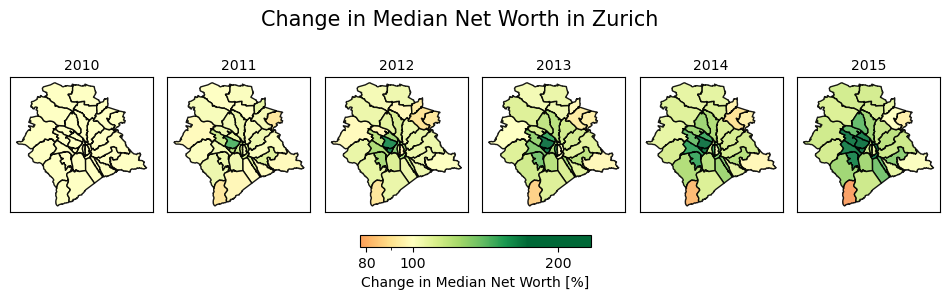

In [ ]:
# calculate and plot the change in median net worth over all tax classes for each district

# for each district, calculate the relative change of median net worth from 2010 to 2015
use_data = new_data
change = use_data.pivot_table(index='District', columns='Year', values='MedianNetWorth', aggfunc='mean')
change = change.div(change[2010], axis=0) * 100
change = change.reset_index().melt(id_vars='District', value_vars=years, var_name='Year', value_name='Change')

# Merge with new_data to include geometry
change = pd.merge(change, new_data[['District', 'geometry']].drop_duplicates(), on='District')
change = gpd.GeoDataFrame(change, geometry='geometry')

# plot the relative change of median net worth from 2010 to 2015 for each district as before
vmin = change['Change'].min()  # Minimum value across all data
vmax = change['Change'].max()  # Maximum value across all data

# Use CustomLogNorm for a custom logarithmic scale
norm = CustomLogNorm(vmin=vmin, vmax=vmax)

years = change.Year.unique()

# Create the subplots grid with additional space for titles
fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(12, 3))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Change in Median Net Worth in Zurich', fontsize=15, y=0.9)

for col_idx in range(len(years)):  # Iterate over columns
    axes[col_idx].set_title(str(years[col_idx]), fontsize=10, pad=5)  # Column labels

    ax = axes[col_idx]  # Access the subplot at (row_idx, col_idx)

    # Select data for the current subplot based on row and column features
    if col_idx < len(years):
        selected_data = change[
            (change['Year'] == years[col_idx])
        ]

        # Plot the selected data
        if not selected_data.empty:
            selected_data.plot(
                ax=ax,
                column='Change',
                cmap='RdYlGn',
                norm=norm,  # Use custom logarithmic normalization
                legend=False,  # Suppress individual colorbars
                edgecolor='black',
                alpha=0.9
            )

    # Clean up the subplot for better readability
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single global colorbar with a custom logarithmic scale
sm = mpl.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array([])  # Needed for ScalarMappable
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
tick_positions = [80, 100, 200]  # Example positions
cbar.set_ticks(tick_positions)  # Set tick positions
cbar.set_ticklabels([f"{pos:.0f}" for pos in tick_positions])  # Set tick labels
cbar.set_label('Change in Median Net Worth [%]')
plt.savefig('Plots/ChangeMedianNetWorthZurichDistrictAllClasses.pdf', bbox_inches='tight')
plt.show()


In [8]:
# print the districts with a negative change in median net worth from 2010 to 2015
change_2015 = change[change['Year'] == 2015]
print("Districts with negative change in median net worth from 2010 to 2015:")
print(change_2015[change_2015['Change'] < 100].District)

# print the districts with a the highest positive change in median net worth from 2010 to 2015
print("Districts that have doubled the median net worth from 2010 to 2015:")
print(change_2015[change_2015['Change'] > 200].District)

Districts with negative change in median net worth from 2010 to 2015:
182    Hirzenbach
187      Leimbach
Name: District, dtype: object
Districts that have doubled the median net worth from 2010 to 2015:
186    Langstrasse
Name: District, dtype: object


Based on this plot and the analysis, one can see that the median net worth in the city center has grown substantially over five years from 2010 to 2015. The only districts that has experienced a decrease in median net worth are Leimbach and Hirzenbach. The district with the highest increase in median net worth is Langstrasse, where the net worth has more than doubled.

### 1.4 Modeling the change in Median Net Worth

In order to better see the trend in the data, let's plot the median net worth as a function of time.

/var/folders/ts/5v2z51y97fg5r998mmnkksy40000gn/T/ipykernel_62082/3948788503.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(data_new.District.unique()))


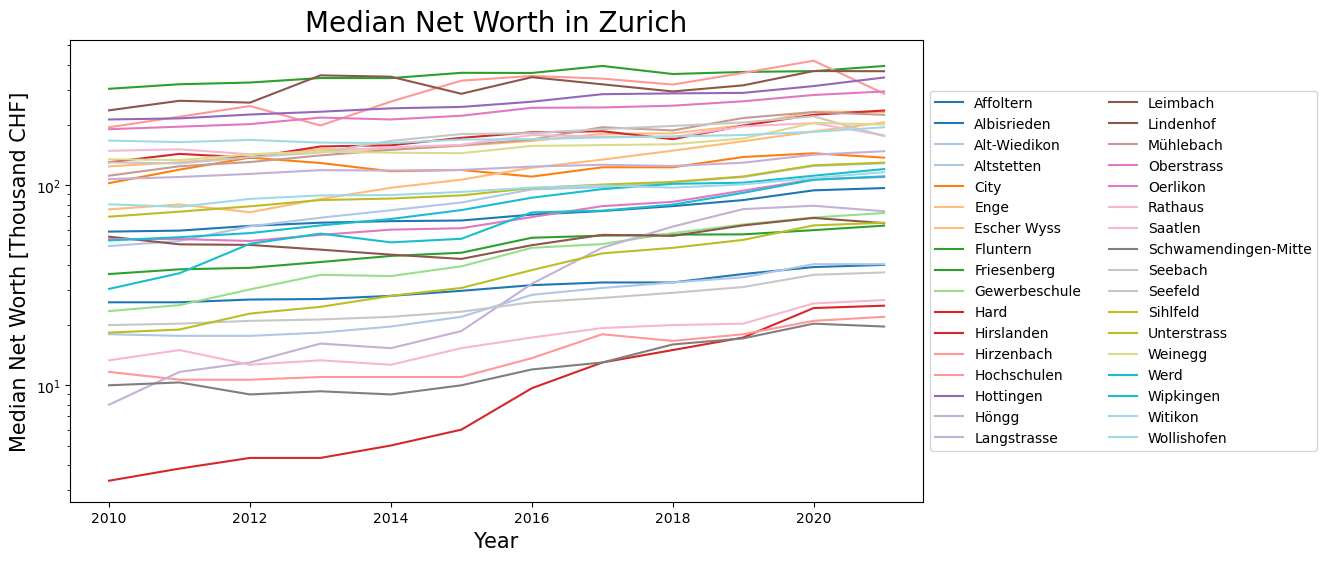

In [52]:
# Filter data from the year 2010 onwards
Vermoegen_filtered = Vermoegen[Vermoegen['StichtagDatJahr'] >= 2010]

data_new = pd.merge(Vermoegen_filtered, Bezirke, left_on='QuarLang', right_on='qname')
data_new = gpd.GeoDataFrame(data_new, geometry='geometry')
data_new = data_new[['StichtagDatJahr','QuarLang','SteuerTarifLang','SteuerVermoegen_p50','geometry']]
data_new.SteuerTarifLang = data_new.SteuerTarifLang.map({'Grundtarif' : 'Base Tariff' , 'Verheiratetentarif' : 'Married Tariff' , 'Einelternfamilientarif' : 'Single-Parent Family Tariff'})
data_new.columns = ['Year','District','TaxClass','MedianNetWorth','geometry']
# calculate the mean median net worth for each district and year, meaning the median net worth over all tax classes
data_new = data_new.groupby(['Year', 'District','geometry']).agg({'MedianNetWorth': 'mean'}).reset_index()

# define a colormap for the districts
cmap = plt.cm.get_cmap('tab20', len(data_new.District.unique()))

# plot all the datapoints
plt.figure(figsize=(11, 6))
plt.title('Median Net Worth in Zurich', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Median Net Worth [Thousand CHF]', fontsize=15)
plt.yscale('log')  # Set y-axis to logarithmic scale
# plt.grid(True)

# Create a color dictionary for districts
colors = {district: cmap(i) for i, district in enumerate(data_new.District.unique())}
years = data_new.Year.unique()
years.sort()

for district in data_new.District.unique():
    plt.plot(years, data_new[data_new['District'] == district]['MedianNetWorth'], label=district, color=colors[district])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.savefig('Plots/MedianNetWorthZurichDistrictsTrend.pdf', bbox_inches='tight')
plt.show()

We now want to fit a linear model on the data. For this we fit a Ridge Regression model to the logarithm of the median net worth. Why the log? Because based on the previous plot and comparing log scale with linenar scale, it can be seen that the median net worth follows roughly an exponential growth.

In [29]:
# fit a model for each district using the data from 2010 to 2015 and make predictions for the coming years (2016-2020)
models = {}
predictions = {}
skipped_districts = []
r2_scores = []
for district in data_new.District.unique():
    try:
        district_data = data_new[data_new['District'] == district]
        X = district_data[(district_data['Year'] < 2016) & (district_data['Year']>=2010)][['Year']]
        y = np.log(district_data[(district_data['Year'] < 2016) & (district_data['Year']>=2010)]['MedianNetWorth'])
        model = RidgeCV(alphas=[0.1, 1.0, 10.0])
        # model = LinearRegression()
        model.fit(X, y)
        models[district] = model

        y_pred = np.exp(model.predict(district_data[district_data['Year'] >= 2016][['Year']]))
        predictions[district] = y_pred
        r2 = r2_score(district_data[district_data['Year'] >= 2016]['MedianNetWorth'], y_pred)
        r2_scores.append(r2)
        # print(f'District: {district}, R2: {r2}')
    except:
        skipped_districts.append(district)
        print(f'Skipped {district}')

best_r2 = max(r2_scores)
worst_r2 = min(r2_scores)
best_district = list(predictions.keys())[r2_scores.index(best_r2)]
worst_district = list(predictions.keys())[r2_scores.index(worst_r2)]
print(f'Best R2: {best_r2}, District: {best_district}')
print(f'Worst R2: {worst_r2}, District: {worst_district}')

perc_negative_r2 = sum([r<0 for r in r2_scores])/len(r2_scores)
print("Percentage of negative R2: {:.4} %".format(perc_negative_r2*100))

Best R2: 0.9347955903425886, District: Werd
Worst R2: -15.214077434115751, District: Leimbach
Percentage of negative R2: 64.71 %


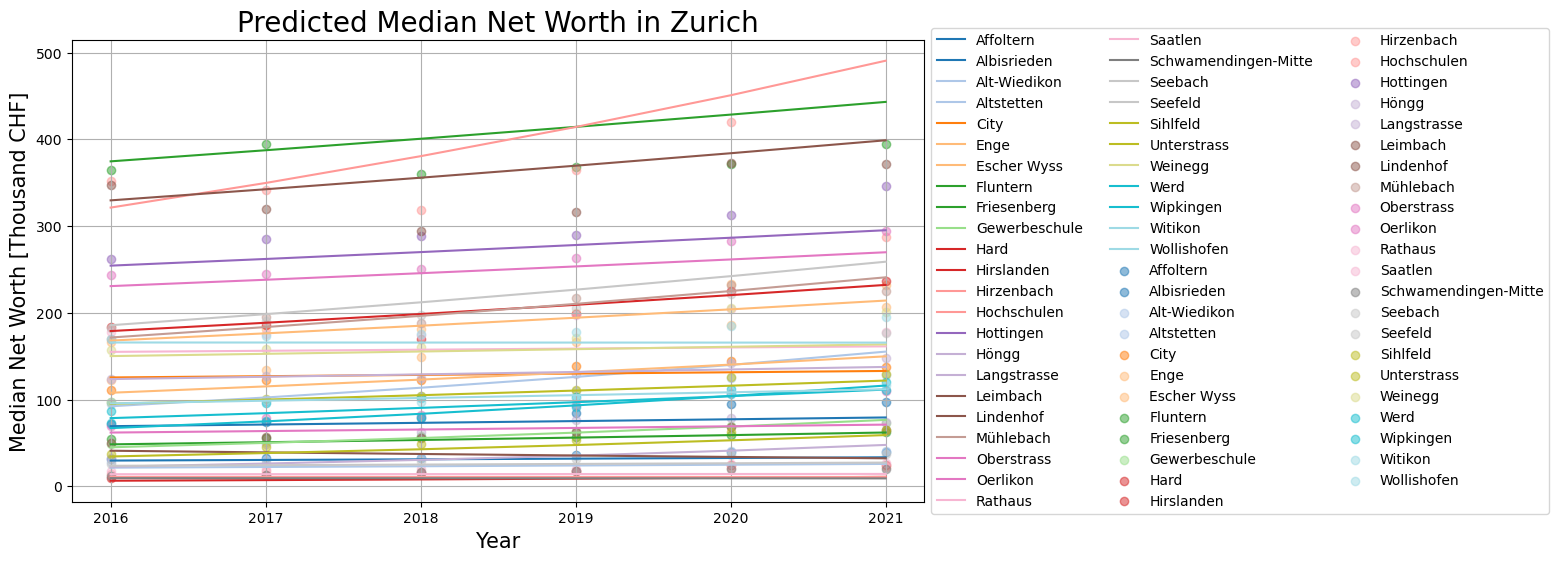

In [46]:
# plot the predicted median net worth for each district from 2010 to 2020
plt.figure(figsize=(11, 6))
plt.title('Predicted Median Net Worth in Zurich', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Median Net Worth [Thousand CHF]', fontsize=15)
plt.xticks(range(2016, 2022))
plt.grid(True)

# Create a color dictionary for districts
colors = {district: cmap(i) for i, district in enumerate(data_new.District.unique())}

for district in data_new.District.unique():
    plt.plot(range(2016, 2022), predictions[district], label=district, color=colors[district])

# plot the datapoints from 2016 to 2020 for each district
for district in data_new.District.unique():
    plt.scatter(data_new[(data_new['District'] == district) & (data_new['Year'] >= 2016)]['Year'], 
                data_new[(data_new['District'] == district) & (data_new['Year'] >= 2016)]['MedianNetWorth'], 
                color=colors[district], alpha=0.5, label=district)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
plt.savefig('Plots/PredictedMedianNetWorthZurichDistricts.pdf', bbox_inches='tight')
plt.show()

As we can see, the predictions are generally very bad as the R2 score is negative for almost 65% of the districts. But there are many reasons why this was expected. Time is not a confounder of median net worth. But, based on the previous plot, time and median net worth seem to be correlated eventhough there is no causal link between the two.

Median net worth is generally infuenced by socio-economic factors like for example rent prices in a given district. We will analyse this in a later chapter. Eventhough these socio-economic factors also change over time, one should rather take these socio-economic factors as predictor variables in a model for predicting median net worth instead of time. The socio-economic parameters have a much closer causal connection to median net worth than time. Eventhough this is a highly interesting topic, we are not going to deal with feature selection and feature engineering in the comming parts of this analysis.

Another point I want to point out regarding the accuracy of the models is that we have a very small number of datapoints. In order to get more reliable estimates, one would need many more datapoints in order to train a reliable and robust model that does not overfit the data. In a more sophisticated setting one could also perform time series analysis to detect a trend and seasonal variablility that one can decouple from the noise.

## 2. Connection between Median Net Worth, Average Living Area and Rent Prices

In this section we want to analyse how median net worth is linked to the average living area and rent prices in each district. We will also analyse the time evolution of both. Due to lack of available data, we will restrict our analysis to the years 2015 to 2021.

### 2.1 Connection between Median Net Worth and Average Living Area

Here we want to analyse if districts with high median net worth have larger or smaller homes than districts with lower median net worth.

In [12]:
Housing = pd.read_csv('Mietbestand.csv')
Housing = Housing[['StichtagDatJahr','QuarLang','Wohnflaeche']]
Housing = Housing.groupby(['StichtagDatJahr','QuarLang']).agg({'Wohnflaeche': 'mean'}).reset_index()
Housing.columns = ['Year','District','AvgLivingArea']
Housing = Housing[Housing['Year'] >= 2015]

# merge the housing data with the median net worth data
data = pd.merge(data_new, Housing, on=['Year', 'District'])

# check if there is a correlation between the average living area and the median net worth
corr = data[['MedianNetWorth', 'AvgLivingArea']].corr()
print(corr)


                MedianNetWorth  AvgLivingArea
MedianNetWorth        1.000000      -0.649709
AvgLivingArea        -0.649709       1.000000


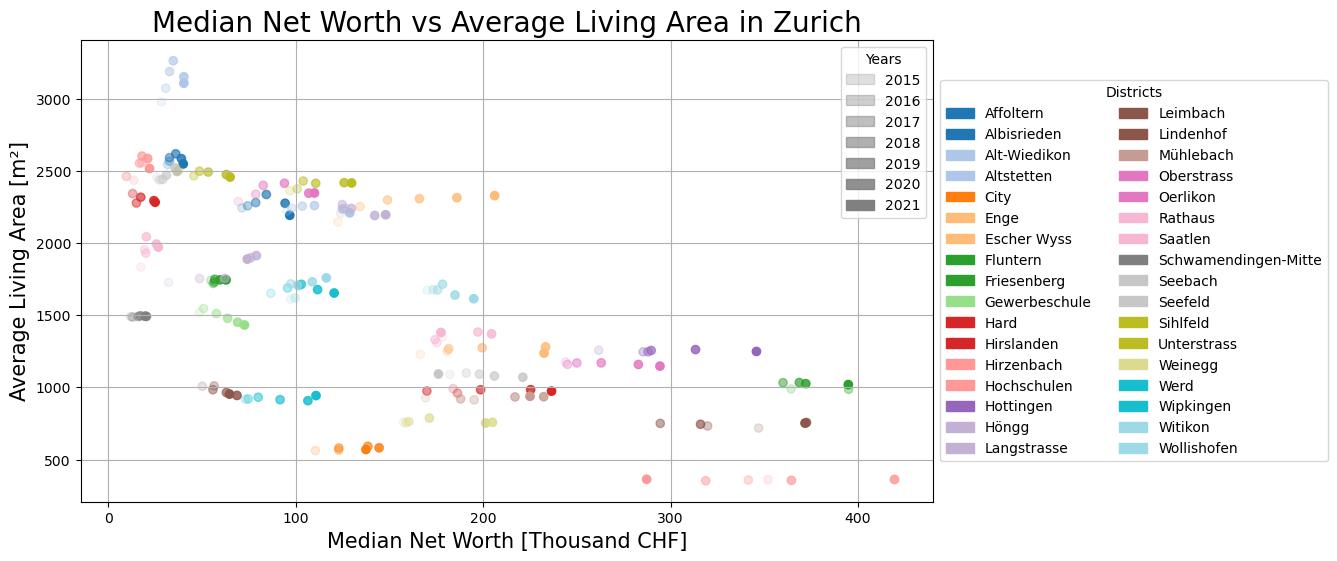

In [ ]:
# Create a color dictionary for districts
colors = {district: cmap(i) for i, district in enumerate(data['District'].unique())}

# Normalize the year values for alpha
year_min = data['Year'].min()
year_max = data['Year'].max()
data['alpha'] = (data['Year'] - year_min) / (year_max - year_min)

# Plot the median net worth against the average living area with colors
plt.figure(figsize=(11, 6))
plt.title('Median Net Worth vs Average Living Area in Zurich', fontsize=20)
plt.xlabel('Median Net Worth [Thousand CHF]', fontsize=15)
plt.ylabel('Average Living Area [m²]', fontsize=15)
plt.grid(True)

for district in data['District'].unique():
    district_data = data[data['District'] == district]
    plt.scatter(district_data['MedianNetWorth'], district_data['AvgLivingArea'], alpha=district_data['alpha'], label=district, color=colors[district])

# Create legend for years
year_legend = plt.legend(handles=[mpatches.Patch(color='gray', alpha=(year - year_min+2) / (year_max - year_min+2), label=str(year)) for year in range(year_min, year_max + 1)], loc='upper right', title='Years')
plt.gca().add_artist(year_legend)

# Create legend for districts
handles = [mpatches.Patch(color=color, label=district) for district, color in colors.items()]
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title='Districts')
plt.savefig('Plots/MedianNetWorthVsAvgLivingAreaZurich.pdf', bbox_inches='tight')
plt.show()

As can be seen in the correlation matrix, there is a negative correlation between median net worth and average living area. This is also supported by the above plot, where one can see a negative trend if one were to make a linear regression between the two parameters median net worth and average living area.

This discovery was really surprising to me in the beginning. However, I quickly realized that the districts with high median net worth are closer to the city center, where space is limited and real estate agencies can demand higher rents due to geographical attractiveness. One example that would support this hypothesis is that average living area is larger in Fluntern than in Rathaus, eventhough median net worth is comparable for the two districts. (Note that Rathaus is much closer to the city center than Fluntern.)

In order to test this hypothesis further, we are going to define a *Hypothesis* parameter in the next section and see how much it correlates with rent prices.

### 2.2 Connection between Hypothesis Parameter and Rent Prices

In this section we will analyse if the previous claim that rent prices are higher closer to the city center is true or not. For this we will use a public dataset on rent prices in Zürich. Unfortunately, data on rent prices is only available for 2022 and 2024. For this reason, we will use the median net worth and average living area from 2021 and rent prices from 2022.

We want to test the following hypothesis. We are going to test if median net worth devided by average living area is correlated with the rent prices in Zürich.

$$
\frac{\text{Median Net Worth}}{\text{Average Living Area}} := \text{Hypothesis} \stackrel{?}{\propto} \text{Rent Price}
$$

To check this, we calculate the *Hypothesis* parameter and check for correlation with rent prices.

In [50]:
Rent = pd.read_csv('Mietpreise.csv')
Rent = Rent[Rent.EinheitLang == 'Quadratmeter']
Rent = Rent[Rent.GemeinnuetzigLang == 'Nicht gemeinnützig']
Rent = Rent[Rent.StichtagDatJahr == 2022]
Rent = Rent[[GL in data.District.unique() for GL in Rent.GliederungLang]]
Rent = Rent[['GliederungLang','mean']]
Rent = Rent.groupby('GliederungLang').agg({'mean': 'mean'}).reset_index()
Rent.columns = ['District','AvgRent']

Hypothesis = pd.merge(data[data.Year == 2021], Rent, on='District')
Hypothesis['Hypothesis'] = Hypothesis['MedianNetWorth'] / Hypothesis['AvgLivingArea']

# calculate the correlation between the hypothesis and the average rent
corr = Hypothesis[['Hypothesis', 'AvgRent']].corr()
print(corr)

            Hypothesis   AvgRent
Hypothesis    1.000000  0.580983
AvgRent       0.580983  1.000000


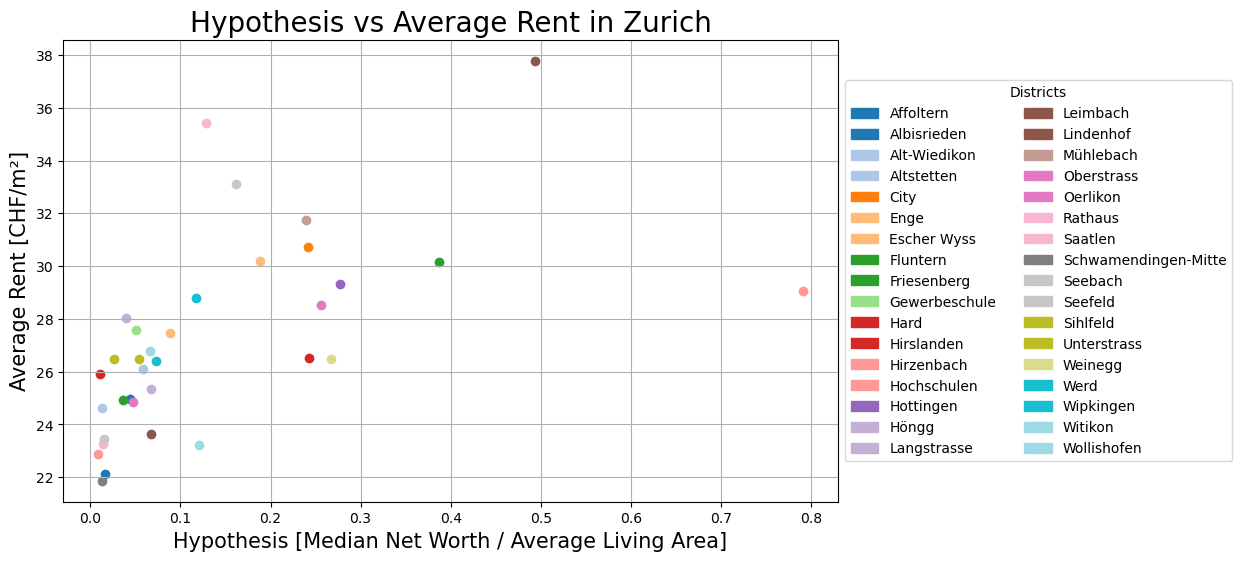

In [51]:
# plot the hypothesis against AvgRent for each district
plt.figure(figsize=(10, 6))
plt.title('Hypothesis vs Average Rent in Zurich', fontsize=20)
plt.xlabel('Hypothesis [Median Net Worth / Average Living Area]', fontsize=15)
plt.ylabel('Average Rent [CHF/m²]', fontsize=15)
plt.grid(True)

for district in Hypothesis['District'].unique():
    district_data = Hypothesis[Hypothesis['District'] == district]
    plt.scatter(district_data['Hypothesis'], district_data['AvgRent'], label=district, color=colors[district])

# Create legend for districts
handles = [mpatches.Patch(color=color, label=district) for district, color in colors.items()]
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title='Districts')
plt.savefig('Plots/HypothesisVsAvgRentZurich.pdf', bbox_inches='tight')
plt.show()

As we can see, the correlation is not very high. But notice that when plotting the hypothesis against the average rent, there is an outlier in the plot. When we delete this outlier we could obtain a much higher correlation. Let's check.

In [16]:
# delete the outliers and recalculate the correlation and replot the hypothesis against AvgRent for each district
Hypothesis = Hypothesis[Hypothesis['Hypothesis'] < 0.7]
print(len(Hypothesis))
corr = Hypothesis[['Hypothesis', 'AvgRent']].corr()
print(corr)

33
            Hypothesis  AvgRent
Hypothesis     1.00000  0.72408
AvgRent        0.72408  1.00000


Indeed, the correlation is now much higher. Now let's also check if this correlation is statistically significant. For this, calculate the p-value.

In [17]:
# calculate the correlation between the hypothesis and the average rent using the Spearman correlation and check for significance
corr, p = stats.pearsonr(Hypothesis['Hypothesis'], Hypothesis['AvgRent'])
print("The p-value is {:.4}".format(p))

The p-value is 1.908e-06


As we can see, the p-value is very small (smaller than say 0.001) which indicates that the correlation is statistically significant.

## Sources

All datasets were retrieved from [data.stadt-zuerich.ch](https://data.stadt-zuerich.ch). More precisely, here is the link to each dataset corresponding to the respective dataframes.

- [Bezirke](https://data.stadt-zuerich.ch/dataset/geo_quartiere__basierend_auf_vermessungsbezirken_)
- [Vermoegen](https://data.stadt-zuerich.ch/dataset/fd_median_vermoegen_quartier_od1004)
- [Housing](https://data.stadt-zuerich.ch/dataset/bau_best_whg_wfl_pers_ea_quartier_jahr_od6982)
- [Rent](https://data.stadt-zuerich.ch/dataset/bau_whg_mpe_mietpreis_raum_zizahl_gn_jahr_od5161)

The direct download links here:
- [Bezirke](https://www.stadt-zuerich.ch/geodaten/download/Quartiere__basierend_auf_Vermessungsbezirken_?format=10005) (You need to select which datatype you wish to download)
- [Vermoegen](https://data.stadt-zuerich.ch/dataset/fd_median_vermoegen_quartier_od1004/download/WIR100OD1004.csv)
- [Housing](https://data.stadt-zuerich.ch/dataset/bau_best_whg_wfl_pers_ea_quartier_jahr_od6982/download/BAU698OD6982.csv)
- [Rent](https://data.stadt-zuerich.ch/dataset/bau_whg_mpe_mietpreis_raum_zizahl_gn_jahr_od5161/download/BAU516OD5161.csv)

If you want to reproduce my results with this script, please make sure to rename the datasets to the names I used.